In [3]:
import numpy as np
import os
from pprint import pprint
from sklearn.preprocessing import normalize
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
from nltk.draw.dispersion import dispersion_plot
import matplotlib.pyplot as plt
import networkx as nx
import collections

# make matplotlib inline
%matplotlib inline

In [19]:
TV_SHOW = 'NCISNOLA'
OUTPUT_DIR = '../models/'+TV_SHOW

In [5]:
# load the data frame
with open('../output/NCISNOLA_preprocessed_tweets_with_userid.csv', 'r') as infile:
  df = pd.read_csv(infile, names=['userid', 'tweets'], delimiter='|')
  df['tweets'] = df.tweets.str.replace(r'\W+',' ')

# Convert the tweet_doc into tweet_tokens and remove non_alphanumeric strings in the tokens
df['tweet_tokens'] = df['tweets'].apply(lambda x: x.split())

df.head()

,userid,tweets,tweet_tokens
0,21973050,explains need watch ncisnola tonight look sto...,"[explains, need, watch, ncisnola, tonight, loo..."
1,39688312,ncisnolas spread beignet ncis great episode r...,"[ncisnolas, spread, beignet, ncis, great, epis..."
2,268594474,follow live tweet ncisnola ncis theme song nc...,"[follow, live, tweet, ncisnola, ncis, theme, s..."
3,325698673,watch gibbs get ready ncisnola great ncis sea...,"[watch, gibbs, get, ready, ncisnola, great, nc..."
4,2493490814,follow live tweet ncisnola ncis time roll nci...,"[follow, live, tweet, ncisnola, ncis, time, ro..."


In [6]:
len(df.userid.tolist())

305

In [7]:
def plot_graph(G):
    pos = nx.spring_layout(G, k=0.3*1/np.sqrt(len(G.nodes())), iterations=20)
    nx.draw_networkx_nodes(G, pos, node_size = 50)
    #nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)
    plt.rcParams['figure.figsize'] = [200, 200]
    plt.title("Retweet Network", { 'fontsize': 20 })
    plt.axis('off')
    plt.rcParams["figure.figsize"] = (30,30)
    plt.show()
    
def remove_isolated_nodes(G):
    print(nx.info(G))
    isolated_nodes = list(nx.isolates(G))
    print('\nIsolated nodes: {}\n'.format(len(isolated_nodes)))
    print('removing isolated nodes...\n')
    G.remove_nodes_from(isolated_nodes)
    print(nx.info(G))
    return G

def get_all_degrees(G):
    return sorted(G.degree, key=lambda x: x[1], reverse=True)

def get_all_in_degrees(G):
    return sorted(G.in_degree, key=lambda x: x[1], reverse=True)

def get_degree(node, G):
    return G.degree[node]

def get_in_degree(node, G):
    return G.in_degree[node]

Name: 
Type: DiGraph
Number of nodes: 6325
Number of edges: 8115
Average in degree:   1.2830
Average out degree:   1.2830

Isolated nodes: 2165

removing isolated nodes...

Name: 
Type: DiGraph
Number of nodes: 4160
Number of edges: 8115
Average in degree:   1.9507
Average out degree:   1.9507


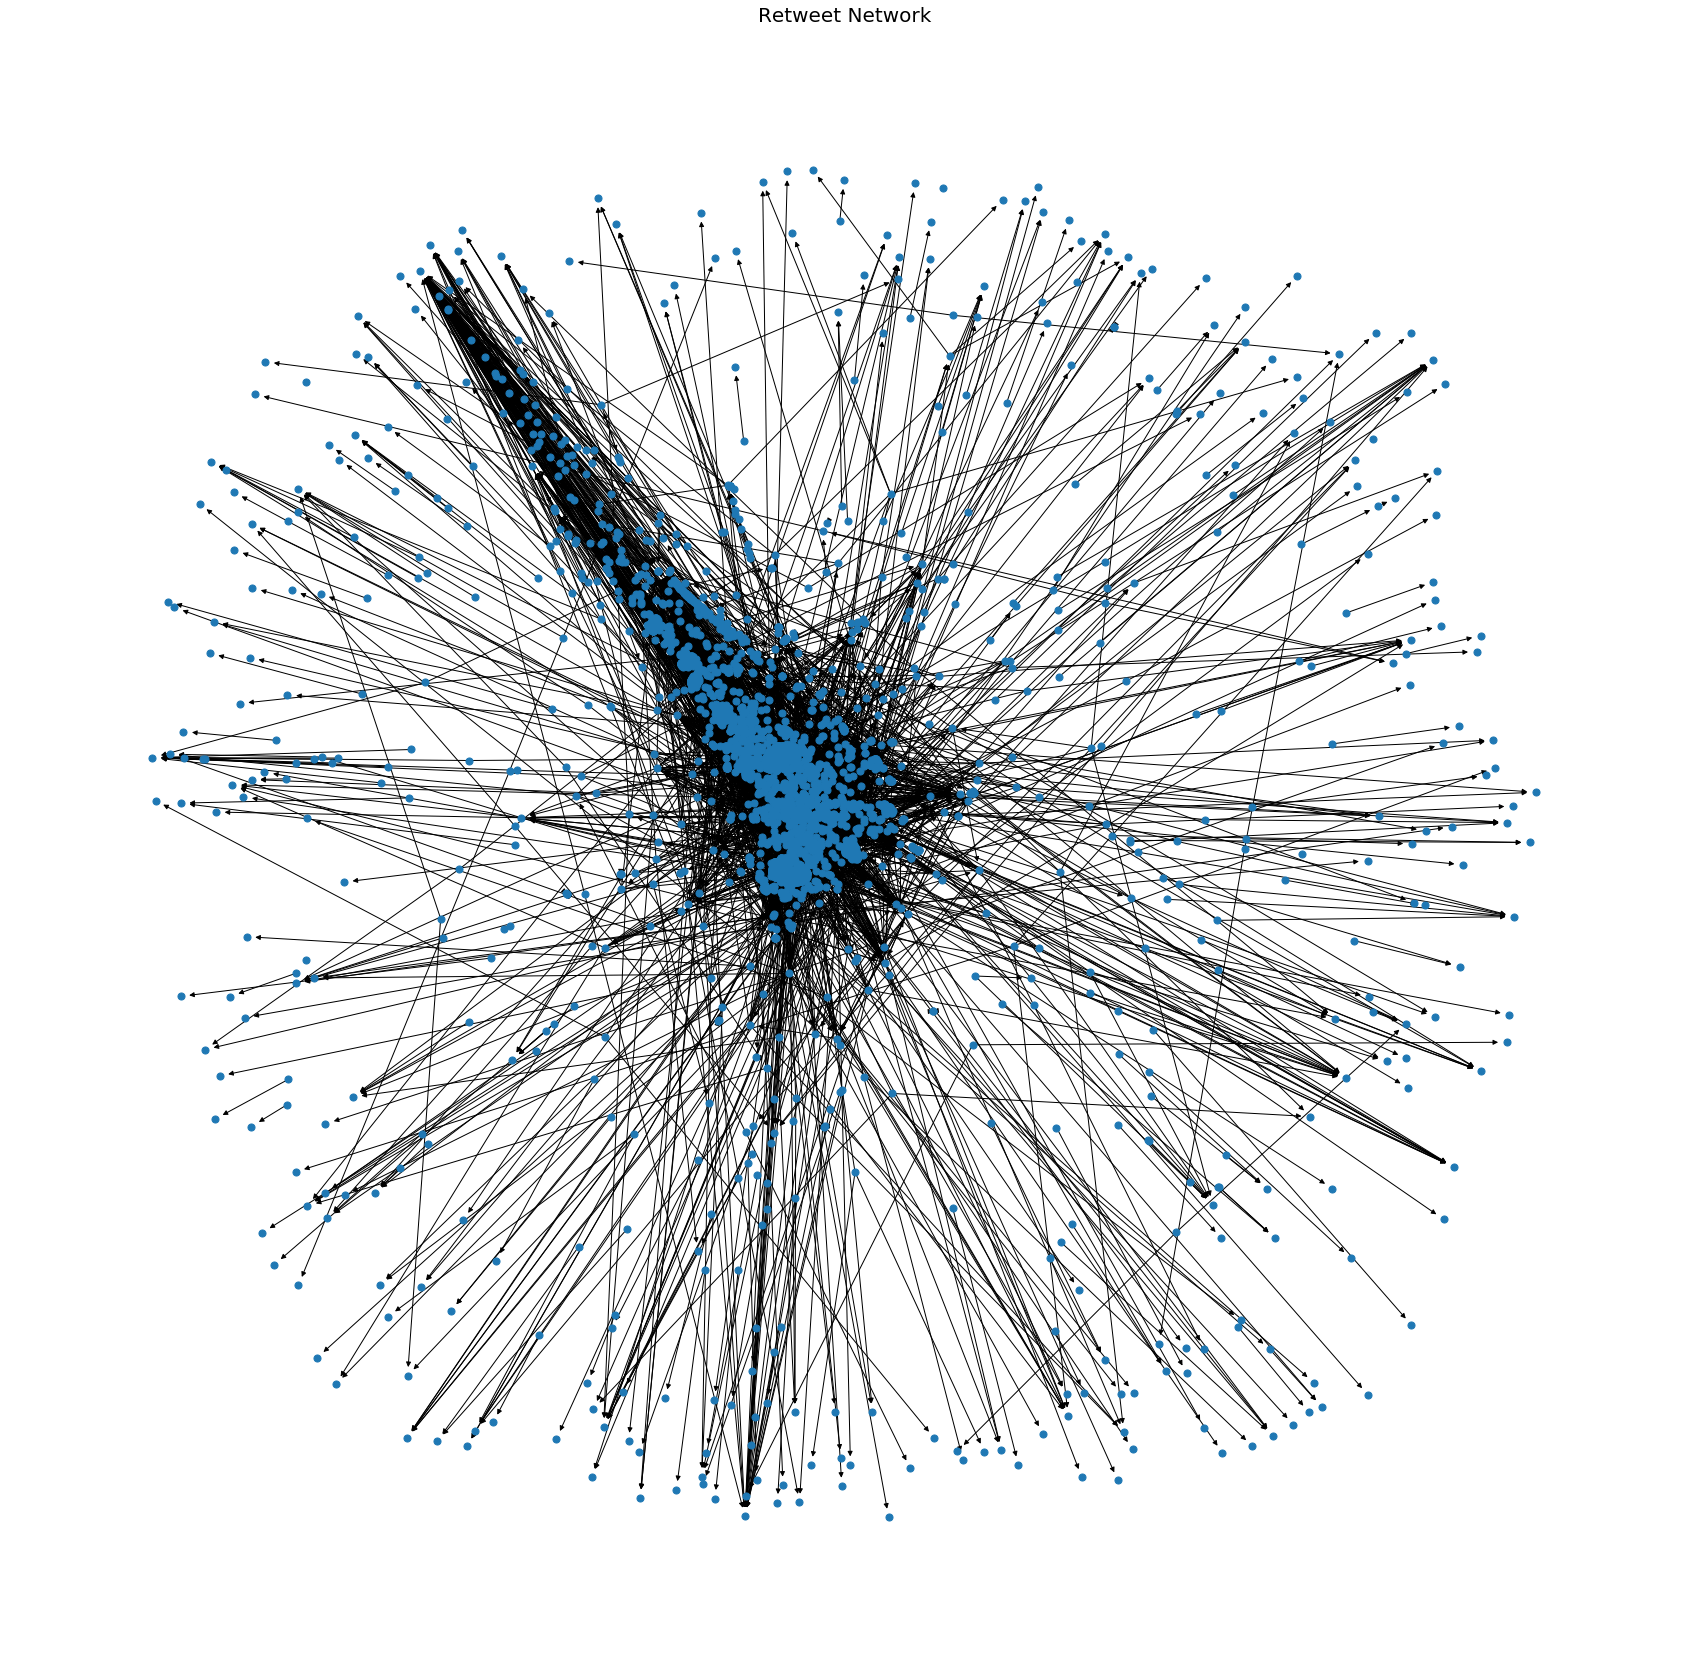

In [9]:
graph = nx.read_graphml('../hazard_model/graphmlFiles/NCISNOLA.graphml')
graph = remove_isolated_nodes(graph)
plot_graph(graph)

In [10]:
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 4160
Number of edges: 8115
Average in degree:   1.9507
Average out degree:   1.9507


In [12]:
def create_Directories(path):
  ''' Checks for the directory. If not present creates the directory'''
  try: 
      os.makedirs(path)
  except OSError:
      if not os.path.isdir(path):
          raise

In [13]:
def sample_data(samples):
    df['tweets'] = df.tweets.str.replace(r'\W+',' ')
    df['tweet_tokens'] = df['tweets'].apply(lambda x: x.split())
    return df.sample(samples)

In [25]:
def create_dict_corpus(doc_list, fname, OUTPUT_DIR=OUTPUT_DIR):
  '''Creates a dictionary and corpus file using a dataframe and saves the file as 'dict' file 
  and 'MM corpus' file given by fname
  '''
  print('Directory: '+OUTPUT_DIR + '/'+ fname + '.dict')
  if not os.path.exists(OUTPUT_DIR + '/'+ fname + '.dict'):
      print('creating dictionary and mm_corpus for the {} samples..'.format(fname))
      dictionary = corpora.Dictionary(doc_list)
      dictionary.save(OUTPUT_DIR + '/' + fname + '.dict')
      doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_list]
      corpora.MmCorpus.serialize(OUTPUT_DIR + '/' + fname + '.mm', doc_term_matrix)
      mm_corpus = corpora.MmCorpus(OUTPUT_DIR + '/' + fname + '.mm')
  else:  
      print('Dictionary and mm_corpus for the file:{} already exists.. loading..'.format(fname))
      dictionary = corpora.Dictionary.load(OUTPUT_DIR + '/' + fname + '.dict') 
      mm_corpus = corpora.MmCorpus(OUTPUT_DIR + '/' + fname + '.mm')
  return (dictionary, mm_corpus)

def get_lda_model(corpus, dictionary, fname, num_topics, passes=20, iterations=100, OUTPUT_DIR=OUTPUT_DIR):
    if not os.path.exists(OUTPUT_DIR + '/'+ fname + '.lda'):
        print('creating lda model for the {} samples..'.format(fname))
        print('num_topics: {}'.format(num_topics))
        lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, 
                                    passes=passes, iterations=iterations, chunksize=2500)
        lda_model.save(OUTPUT_DIR + '/' + fname + '.lda')
    else:
        print('LDA model for the file:{} already exists.. loading..'.format(fname))
        lda_model = LdaMulticore.load(OUTPUT_DIR + '/' + fname + '.lda')
    return lda_model

In [15]:
def _extract_data(topic_model, corpus, dictionary, doc_topic_dists=None):
    import gensim

    if not gensim.matutils.ismatrix(corpus):
        corpus_csc = gensim.matutils.corpus2csc(corpus, num_terms=len(dictionary))
    else:
        corpus_csc = corpus
        # Need corpus to be a streaming gensim list corpus for len and inference functions below:
        corpus = gensim.matutils.Sparse2Corpus(corpus_csc)

    vocab = list(dictionary.token2id.keys())
    # TODO: add the hyperparam to smooth it out? no beta in online LDA impl.. hmm..
    # for now, I'll just make sure we don't ever get zeros...
    beta = 0.01
    fnames_argsort = np.asarray(list(dictionary.token2id.values()), dtype=np.int_)
    term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]
    term_freqs[term_freqs == 0] = beta
    doc_lengths = corpus_csc.sum(axis=0).A.ravel()

    assert term_freqs.shape[0] == len(dictionary),\
        'Term frequencies and dictionary have different shape {} != {}'.format(
        term_freqs.shape[0], len(dictionary))
    assert doc_lengths.shape[0] == len(corpus),\
        'Document lengths and corpus have different sizes {} != {}'.format(
        doc_lengths.shape[0], len(corpus))

    if hasattr(topic_model, 'lda_alpha'):
        num_topics = len(topic_model.lda_alpha)
    else:
        num_topics = topic_model.num_topics

    if doc_topic_dists is None:
        # If its an HDP model.
        if hasattr(topic_model, 'lda_beta'):
            gamma = topic_model.inference(corpus)
        else:
            gamma, _ = topic_model.inference(corpus)
        doc_topic_dists = gamma / gamma.sum(axis=1)[:, None]
    else:
        if isinstance(doc_topic_dists, list):
            doc_topic_dists = gensim.matutils.corpus2dense(doc_topic_dists, num_topics).T
        elif issparse(doc_topic_dists):
            doc_topic_dists = doc_topic_dists.T.todense()
        doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1)

    assert doc_topic_dists.shape[1] == num_topics,\
        'Document topics and number of topics do not match {} != {}'.format(
        doc_topic_dists.shape[1], num_topics)

    # get the topic-term distribution straight from gensim without
    # iterating over tuples
    if hasattr(topic_model, 'lda_beta'):
        topic = topic_model.lda_beta
    else:
        topic = topic_model.state.get_lambda()
    topic = topic / topic.sum(axis=1)[:, None]
    topic_term_dists = topic[:, fnames_argsort]

    assert topic_term_dists.shape[0] == doc_topic_dists.shape[1]

    return doc_topic_dists

In [16]:
def get_DT(doc_topic_dist):
    DT_matrix = np.asmatrix(doc_topic_dist)

def get_DT_row_norm(doc_topic_dist):
    DT_row_norm = np.asmatrix(normalize(doc_topic_dist, axis=1, norm='l1'))
    return DT_row_norm

def get_DT_col_norm(doc_topic_dist):
    DT_col_norm = np.asmatrix(normalize(doc_topic_dist, axis=0, norm='l1'))
    return DT_col_norm

def get_sim(DT_row_norm, i, j, k):
    #print('DT_row_norm: {}'.format(DT_row_norm))
    #print('i: {0}, j: {1}, k: {2}'.format(i, j, k))
    sim = 1 - abs(DT_row_norm.item((i,k))-DT_row_norm.item(j,k))
    return sim    

def get_weight(nodei, nodej, graph):
    ''' Adds weights to the Transition matrix by accepting two nodes: node1, nodej.
    weight is computed as follows:
    
        weight = (sum of weighted in-degrees of nodej)/(sum of weighted degrees of node1)
        Returns 0.0 if both numerator and denominator of the above expression is 0
    '''
    weight = 0.0
    degree_list = ['retweet_count', 'mention_count', 'reply_count', 'quote_count']
    nodej_in_degree = sum([graph.in_degree(nodej, weight=value) for value in degree_list])
    nodei_degree = sum([graph.degree(nodei, weight=value) for value in degree_list])
    if nodei_degree==0 or nodej_in_degree==0:
        return 0.0
    else: 
        return nodej_in_degree/nodei_degree
    
    
def get_Pt(DT_row_norm, data, samples, k):
    Pt = list()
    trans_mat = np.zeros((samples, samples))
    for i in range(0, samples):
        for j in range(0, samples):
            if graph.has_node(str(data['userid'].iloc[i])) and graph.has_node(str(data['userid'].iloc[j])):
                trans_mat[i][j] = get_weight(str(data['userid'].iloc[i]), str(data['userid'].iloc[j]), graph) * get_sim(DT_row_norm, i, j, k)    
            else:
                trans_mat[i][j] = 0.0      
    return trans_mat

def get_DT_column_norm_to_list(doc_topic_dist):
    temp = np.array(normalize(doc_topic_dist, axis=0, norm='l1'))
    mat = temp.reshape(temp.shape).tolist()
    return mat

def get_TRt(gamma, trans_mat, Et, iter=1000, tolerance=1e-16):
    TRt = Et
    old_TRt = TRt
    i = 0
    # np.linalg.norm(old_TRt,new_TRt)
    while i < iter:
        TRt = (gamma*np.dot(trans_mat,old_TRt)) + ((1 - gamma) * Et)
        #print(TRt)
        euclidean_dis = np.linalg.norm(TRt - old_TRt)
        #print(euclidean_dis,'\n')
        if euclidean_dis < tolerance:
            break
        old_TRt = TRt
        i += 1
    return TRt

def get_TR(DT_row_norm, DT_col_norm, data, num_topics, samples, gamma, tolerance):
    for k in range(0, num_topics):
        trans_mat = get_Pt(DT_row_norm, data, samples, k)
        Et = DT_col_norm[:,k]
        #TR.append(np.array(get_TRt(gamma, trans_mat, Et)).reshape(-1, ).tolist())
        if k==0:
            TR = get_TRt(gamma, trans_mat, Et)
        else:
            TR = np.concatenate((TR, get_TRt(gamma, trans_mat, Et)), axis=1)
    return TR

def get_TR_sum(TR, samples, num_topics):
    TR_sum = [0 for i in range(0, samples)]
    for i in range(0, num_topics):
        for j in range(0, samples):
            TR_sum[j] += TR[i][j]
    TR_sum.sort()
    return TR_sum


In [30]:
def get_doc_topic_dists(data, num_topics, samples, TV_SHOW, SAVE_DIR, passes=1, iterations=50):
    create_Directories(SAVE_DIR)
    (dictionary, corpus) = create_dict_corpus(list(data['tweet_tokens']), TV_SHOW, 
                                              OUTPUT_DIR=SAVE_DIR)
    print('Num_topics: {}'.format(num_topics))
    print('Computing LDA model...')
    lda_model = get_lda_model(corpus=corpus, dictionary=dictionary, fname= 'data_{0}'.format(samples), num_topics=num_topics, 
                              passes=passes, iterations=iterations, OUTPUT_DIR=SAVE_DIR)
    print('Finished computing LDA model...')
    doc_topic_dist = _extract_data(lda_model, corpus, dictionary)
    return doc_topic_dist

In [29]:
def twitter_rank(data, samples, num_topics, SAVE_DIR, TV_SHOW, passes=20, iterations=100, gamma=0.2, tolerance=1e-16):
    #data = sample_data(samples)
    #data = df.iloc[:samples, :]
    #pprint(data)
    print('samples: {0}, num_topics: {1}'.format(len(data), num_topics))
    doc_topic_dist = np.mat(get_doc_topic_dists(data, num_topics, samples, TV_SHOW, SAVE_DIR))
    #pprint(doc_topic_dist)
    DT_row_norm = get_DT_row_norm(doc_topic_dist)
    DT_col_norm = get_DT_col_norm(doc_topic_dist)
    #pprint(DT_col_norm)
    TR = get_TR(DT_row_norm, DT_col_norm, data, num_topics,
                samples=samples, gamma=gamma, tolerance=tolerance)
    TR_sum = np.sum(TR, axis=1).tolist()
    TR_sum = [item for sublist in TR_sum for item in sublist]
    users = list()
    for index in sorted(range(len(TR_sum)), key=lambda i: TR_sum[i], reverse=True):
       users.append((index, data['userid'].iloc[index]))
    top_users = list()
    for index in sorted(range(len(TR_sum)), key=lambda i: TR_sum[i], reverse=True)[:num_topics]:
       top_users.append((index, data['userid'].iloc[index]))
    return (TR, TR_sum, doc_topic_dist, users, top_users)

## Testing for top 100 samples and 3 topics

In [ ]:
SAVE_DIR_1 = OUTPUT_DIR+'/df_10_p1_i50_1'
SAVE_DIR_2 = OUTPUT_DIR+'/df_10_p1_i50_2'
data = df.iloc[:100, :]
(TR1, TR_sum1, doc_topic_dist1, users1, top_users1) = twitter_rank(data=data, samples=100, num_topics=3, SAVE_DIR=SAVE_DIR_1)

In [ ]:
# TOP influencial users for the 3 topics
top_users1

In [ ]:
len(users)

In [ ]:
TR1

In [ ]:
TR_sum1

In [ ]:
pprint(data[data['userid'].isin([str(user[1]) for user in top_users1])])

In [ ]:
for user in top_users1:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR_sum1[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
 for user in top_users1:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR1[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
for user in users1:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR_sum1[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
# Plotting histogram for top 100 samples
import collections

top100_Week0 = nx.read_graphml('../hazard_model/graphmlFiles/Top100_Week0.graphml')
top100_Week0.remove_edges_from(top100_Week0.selfloop_edges())
print('Top 100 Week 0 : {}\n'.format(nx.info(top100_Week0)))
top100_Week1 = nx.read_graphml('../hazard_model/graphmlFiles/Top100_Week1.graphml')
top100_Week1.remove_edges_from(top100_Week1.selfloop_edges())
print('Top 100 Week 1 : {}\n'.format(nx.info(top100_Week1)))
top100_Week2 = nx.read_graphml('../hazard_model/graphmlFiles/Top100_Week2.graphml')
top100_Week2.remove_edges_from(top100_Week2.selfloop_edges())
print('Top 100 Week 2 : {}\n'.format(nx.info(top100_Week2)))

In [24]:
def plot_hist(G, xlabel, ylabel, title):
    G = G.to_undirected()
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # draw graph in inset
    
    plt.axes([0.4, 0.4, 0.5, 0.5])
    #Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
    pos = nx.spring_layout(G)
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='red')
    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='black', arrows=True)

    plt.rcParams["figure.figsize"] = (10,3)
    plt.show()

In [ ]:
plot_hist(top100_Week0, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Top 100 Week 0)')
plot_hist(top100_Week1, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Top 100 Week 1)')
plot_hist(top100_Week2, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Top 100 Week 2)')
plt.savefig('../output/top100_hist.png')

## Testing for bottom 100 samples and 3 topics

In [ ]:
TV_SHOW='NCISNOLA'
SAVE_DIR_2 = OUTPUT_DIR+'/df_10_p1_i50_2'
data = df.iloc[-100: ,:]
(TR, TR_sum, doc_topic_dist, users, top_users) = twitter_rank(data=data, samples=100, num_topics=3, SAVE_DIR=SAVE_DIR_2)

In [ ]:
# TOP influencial users for the 6 topics
top_users

In [ ]:
len(users)

In [ ]:
TR

In [ ]:
len(TR_sum)

In [ ]:
print(data[data['userid'].isin([str(user[1]) for user in top_users])])

In [ ]:
for user in top_users:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR_sum[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
for user in users:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR_sum[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
# Plotting histogram for top 100 samples
import collections

bot100_Week0 = nx.read_graphml('../hazard_model/graphmlFiles/bot100_Week0.graphml')
bot100_Week0.remove_edges_from(bot100_Week0.selfloop_edges())
print('Top 100 Week 0 : {}\n'.format(nx.info(bot100_Week0)))
bot100_Week1 = nx.read_graphml('../hazard_model/graphmlFiles/bot100_Week1.graphml')
bot100_Week1.remove_edges_from(bot100_Week1.selfloop_edges())
print('Top 100 Week 1 : {}\n'.format(nx.info(bot100_Week1)))
bot100_Week2 = nx.read_graphml('../hazard_model/graphmlFiles/bot100_Week2.graphml')
bot100_Week2.remove_edges_from(bot100_Week2.selfloop_edges())
print('Top 100 Week 2 : {}\n'.format(nx.info(bot100_Week2)))

In [ ]:
plot_hist(bot100_Week0, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Bot 100 Week 0)')
plot_hist(bot100_Week1, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Bot 100 Week 1)')
plot_hist(bot100_Week2, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Bot 100 Week 2)')

## PHASE 2: COMMUNITY DETECTION

## Testing for all samples and 3 topics

In [16]:
SAVE_DIR_1 = OUTPUT_DIR+'/df_p1_i50'
data = df
(TR1, TR_sum1, doc_topic_dist1, users1, top_users1) = twitter_rank(data=data, samples=2167, num_topics=3, 
                                                                   SAVE_DIR=OUTPUT_DIR+'/df_p1_i50')

samples: 2167, num_topics: 3
creating dictionary and mm_corpus for the data_2167 samples..
Num_topics: 3
Computing LDA model...
creating lda model for the data_2167 samples..
num_topics: 3
Finished computing LDA model...


In [17]:
# TOP influencial users for the 3 topics
top_users1

[(0, 932563433605812226), (1, 858771417382387713), (2, 936079485186822144)]

In [19]:
len(users1)

2167

In [20]:
TR1

matrix([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])

In [21]:
TR_sum1

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [ ]:
pprint(data[data['userid'].isin([str(user[1]) for user in top_users1])])

In [ ]:
for user in top_users1:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR_sum1[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
 for user in top_users1:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR1[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
for user in users1:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR_sum1[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
# Plotting histogram for top 100 samples
import collections

top100_Week0 = nx.read_graphml('../hazard_model/graphmlFiles/Top100_Week0.graphml')
top100_Week0.remove_edges_from(top100_Week0.selfloop_edges())
print('Top 100 Week 0 : {}\n'.format(nx.info(top100_Week0)))
top100_Week1 = nx.read_graphml('../hazard_model/graphmlFiles/Top100_Week1.graphml')
top100_Week1.remove_edges_from(top100_Week1.selfloop_edges())
print('Top 100 Week 1 : {}\n'.format(nx.info(top100_Week1)))
top100_Week2 = nx.read_graphml('../hazard_model/graphmlFiles/Top100_Week2.graphml')
top100_Week2.remove_edges_from(top100_Week2.selfloop_edges())
print('Top 100 Week 2 : {}\n'.format(nx.info(top100_Week2)))

In [55]:
def plot_hist(G, xlabel, ylabel, title):
    G = G.to_undirected()
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

#     # draw graph in inset
    
#     plt.axes([0.4, 0.4, 0.5, 0.5])
#     #Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
#     pos = nx.spring_layout(G)
#     plt.axis('off')
#     nx.draw_networkx_nodes(G, pos, node_size=20, node_color='red')
#     nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='black', arrows=True)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.show()

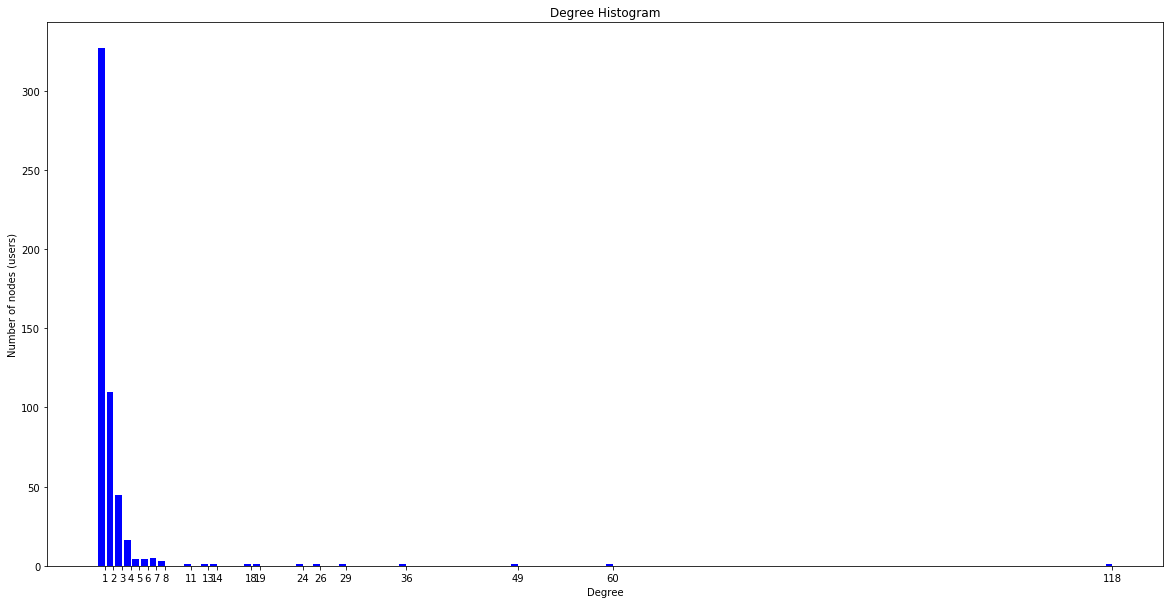

In [56]:
plot_hist(graph, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram')

In [ ]:
plot_hist(top100_Week0, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Top 100 Week 0)')
plot_hist(top100_Week1, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Top 100 Week 1)')
plot_hist(top100_Week2, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Top 100 Week 2)')
plt.savefig('../output/top100_hist.png')

In [26]:
doc_topic_dist1

matrix([[2.10084647e-04, 9.99580622e-01, 2.09260732e-04],
        [4.72365379e-01, 2.21544094e-02, 5.05480230e-01],
        [3.98197353e-01, 3.92403007e-02, 5.62562346e-01],
        ...,
        [5.48456550e-01, 1.31303230e-02, 4.38413113e-01],
        [6.08217029e-04, 9.98776495e-01, 6.15209108e-04],
        [1.12034060e-04, 9.99774873e-01, 1.13092545e-04]], dtype=float32)

In [27]:
get_DT_row_norm(doc_topic_dist1)

matrix([[2.10084647e-04, 9.99580622e-01, 2.09260732e-04],
        [4.72365379e-01, 2.21544094e-02, 5.05480230e-01],
        [3.98197353e-01, 3.92403007e-02, 5.62562346e-01],
        ...,
        [5.48456550e-01, 1.31303230e-02, 4.38413113e-01],
        [6.08217088e-04, 9.98776615e-01, 6.15209166e-04],
        [1.12034060e-04, 9.99774873e-01, 1.13092545e-04]], dtype=float32)

In [28]:
get_DT_col_norm(doc_topic_dist1)

matrix([[2.01877882e-07, 2.22780881e-03, 3.08796587e-07],
        [4.53912857e-04, 4.93764928e-05, 7.45914294e-04],
        [3.82642145e-04, 8.74565594e-05, 8.30147823e-04],
        ...,
        [5.27031603e-04, 2.92641216e-05, 6.46946370e-04],
        [5.84457609e-07, 2.22601648e-03, 9.07836238e-07],
        [1.07657556e-07, 2.22824165e-03, 1.66885556e-07]], dtype=float32)

In [29]:
SAVE_DIR_1 = OUTPUT_DIR+'/df_p1_i50'
data = df
(TR1, TR_sum1, doc_topic_dist1, users1, top_users1) = twitter_rank(data=data, samples=2167, num_topics=3, 
                                                                   SAVE_DIR=OUTPUT_DIR+'/df_p1_i50')

samples: 2167, num_topics: 3
Dictionary and mm_corpus for the file:data_2167 already exists.. loading..
Num_topics: 3
Computing LDA model...
LDA model for the file:data_2167 already exists.. loading..
Finished computing LDA model...


In [30]:
TR1

matrix([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])

In [31]:
TR_sum1

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [57]:
a = 'asdasf'

In [59]:
list(a)

['a', 's', 'd', 'a', 's', 'f']

In [61]:
stack = [(3, 1)]
(node, depth) = stack.pop()

In [63]:
{1, 2}

{1, 2}

In [67]:
num=10
for i in [x for x in range(2, num+1) if x*x<=num]:
    print(i)

2
3


In [83]:
('-210')[:0:-1]

'012'

In [86]:
x = 1534236469
if x>=0 and x in range(-2**31, (2**31)-1):
        print(True)

True


In [89]:
print(2**31)
print(x)

2147483648
1534236469


In [90]:
'in' in 'inside'

True

In [91]:
x

1534236469

In [97]:
str(x)[:-1]

'153423646'

In [100]:
sorted(['flower', 'flow'])

['flow', 'flower']

In [101]:
102//10

10

In [103]:
102//100

1

In [105]:
for i in 'leetcode':
    print(i)

l
e
e
t
c
o
d
e


In [132]:
[0,1,0,3,12].remove(0)

In [137]:
def missingNumber(nums) -> int:
        return set(list(range(len(nums)+1))).difference(set(nums)).pop()

nums = [9,6,4,2,3,5,7,0,1,0,0]
print(missingNumber(nums))

8


In [138]:
nums.remove(0)
nums

[9, 6, 4, 2, 3, 5, 7, 1, 0, 0]

In [145]:
import collections
count_dict = collections.Counter([2,2,1,1,1,2,2])
for i,j in count_dict.items():
    print(i, j)

2 4
1 3


In [31]:
SAVE_DIR_1 = OUTPUT_DIR
TV_SHOW = 'NCISNOLA'
data = df
(TR, TR_sum, doc_topic_dist, users, top_users) = twitter_rank(data=data, samples=305, TV_SHOW = 'NCISNOLA', 
                                                              num_topics=10, SAVE_DIR=SAVE_DIR_1)

samples: 305, num_topics: 10
Directory: ../models/NCISNOLA/NCISNOLA.dict
Dictionary and mm_corpus for the file:NCISNOLA already exists.. loading..
Num_topics: 10
Computing LDA model...
LDA model for the file:data_305 already exists.. loading..
Finished computing LDA model...


In [32]:
TR

matrix([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])

In [33]:
TR_sum

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [34]:
samples = 305
DT_row_norm = get_DT_row_norm(doc_topic_dist)
DT_col_norm = get_DT_col_norm(doc_topic_dist)
trans_mat = get_Pt(DT_row_norm, data, samples, 0)
print(trans_mat)

[[2.71739130e-02 4.33643746e+00 2.39018626e-01 ... 2.17363733e-02
  2.17062345e-02 4.34289544e-02]
 [4.05795583e-03 6.47727273e-01 3.56933126e-02 ... 3.24595289e-03
  3.24145164e-03 6.48536538e-03]
 [6.84611257e-02 1.09250873e+01 6.02739726e-01 ... 5.47758500e-02
  5.47372249e-02 1.09516002e-01]
 ...
 [6.24920733e-01 9.97254106e+01 5.49812594e+00 ... 5.00000000e-01
  4.99306808e-01 9.98992779e-01]
 [1.24810849e+00 1.99174238e+02 1.09884979e+01 ... 9.98613617e-01
  1.00000000e+00 1.99924167e+00]
 [2.27014989e-01 3.62272510e+01 1.99866704e+00 ... 1.81635051e-01
  1.81749243e-01 3.63636364e-01]]


In [36]:
k=0
Et = DT_col_norm[:,k]
Et

matrix([[1.22577534e-04],
        [4.18984237e-05],
        [4.37766808e-04],
        [1.43438950e-03],
        [7.66121957e-04],
        [5.91371849e-04],
        [3.70416674e-04],
        [2.95685662e-04],
        [6.60944555e-04],
        [4.06122301e-04],
        [8.75539670e-04],
        [1.05347892e-03],
        [2.85666640e-04],
        [3.72470618e-04],
        [1.29647017e-03],
        [7.40837946e-04],
        [8.32299411e-04],
        [1.89905928e-04],
        [6.94994931e-04],
        [1.58254858e-04],
        [4.03699145e-04],
        [4.21350996e-04],
        [9.14747434e-05],
        [4.78141970e-04],
        [3.80889018e-04],
        [1.35375944e-04],
        [4.20569268e-05],
        [4.37769078e-04],
        [1.08386979e-04],
        [3.03676614e-04],
        [9.75625153e-05],
        [8.53372912e-04],
        [1.48500447e-04],
        [1.02146785e-03],
        [1.00622256e-03],
        [2.34899402e-04],
        [4.73431719e-05],
        [7.74903674e-05],
        [1.8

In [40]:
iter = 100
gamma=0.2
tolerance=1e-16
TRt = Et
old_TRt = TRt
i = 0
# np.linalg.norm(old_TRt,new_TRt)
while i < iter:
    TRt = (gamma*np.dot(trans_mat,old_TRt)) + ((1 - gamma) * Et)
    #print(TRt)
    euclidean_dis = np.linalg.norm(TRt - old_TRt)
    print(euclidean_dis,'\n')
    if euclidean_dis < tolerance:
        break
    old_TRt = TRt
    i += 1
 

1.2837549622812143 

23.295021287840047 

425.122500620425 

7758.21981744284 

141582.65711398915 

2583794.8995239343 

47152640.15301636 

860506177.8740661 

15703699299.901579 

286582685915.1496 

5229954693978.126 

95443400614795.83 

1741782339224698.2 

3.1786437801806016e+16 

5.800826000898721e+17 

1.0586144475361993e+19 

1.9319051258540566e+20 

3.5256059691869583e+21 

6.434010285298922e+22 

1.1741666174021934e+24 

2.1427806053898096e+25 

3.910440524184964e+26 

7.136309267838541e+27 

1.3023317872058091e+29 

2.376674020575884e+30 

4.337281371438786e+31 

7.91526710527666e+32 

1.444486718349372e+34 

2.6360978748231484e+35 

4.8107136724578677e+36 

8.779251430459762e+37 

1.6021584514684038e+39 

2.9238389217396035e+40 

5.335823078200701e+41 

9.737543238161607e+42 

1.7770407100349575e+44 

3.242988100680037e+45 

5.918250359579793e+46 

1.080043658233641e+48 

1.97101209448248e+49 

3.5969737398854414e+50 

6.564252001113463e+51 

1.1979349155741806e+53 

2.18

In [42]:
from collections import Counter
list = [1,2,3,4,1,2,6,7,3,8,1]  
cnt = Counter(list)  
print(cnt)

Counter({1: 3, 2: 2, 3: 2, 4: 1, 6: 1, 7: 1, 8: 1})
